In [1]:
import string
import re
import numpy as np
import pandas as pd
import seaborn as sn
import wordcloud
import matplotlib.pyplot as plt

import nltk 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
  
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/drive/MyDrive/movie.csv')
df.head()

,text,label
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.",0
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that ba...",0
2,"Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? ""I'll show those old meanies, I'll put out my own movie and prove that you don't have to know nuttin about your topic to still make money!"" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I'm running the other way. It's child abuse to let parents that worthless raise kids. It's audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.",0
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn't cash the cheque (something that is rarely done now).<br /><br />It follows through the early years of getting equipment and uniforms, starting up and training. All in all, its a great film for a boring Sunday afternoon. <br /><br />Two draw backs. One is the Germans bogus dodgy accents (come one, Germans cant pronoun

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
# check missing value
df.isna().sum() 

text     0
label    0
dtype: int64

In [6]:
# handling dupliacated data
df.duplicated().sum()

277

In [7]:
df.drop_duplicates(inplace=True)

Text(0, 0.5, 'Movie Sentiment')

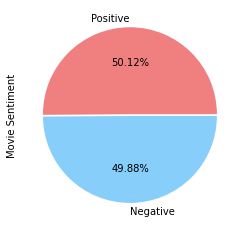

In [9]:
plt.pie(df['label'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01],colors=['lightcoral','lightskyblue'])
plt.ylabel('Movie Sentiment')

In [10]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)
def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

def remove_URLs(text):
    return re.sub(r'http\S+', ' ', text,  flags=re.MULTILINE)
  
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


In [11]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = remove_URLs(text)
    text = remove_html(text)
    return text

In [12]:
df["cleaned_text"] = df["text"].apply(preprocess_text)
df.head()

,text,label,cleaned_text
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.",0,i grew up b 1965) watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point was the snappy theme tune not that it could compare with the original score of the thunderbirds thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created jonatha frakes should hand in his directors chair his version was completely hopeless a waste of film utter rubbish a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp sapiens was a huge error of judgment
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that ba...",0,when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strong points of the first movie: awsome animation good flowing story excellent voice cast funny comedy and a kick ass soundtrack but to my disappointment not any of this is to be found in atlantis: milo s return had i read some reviews first i might not have been so let down the following paragraph will be directed to those who have seen the first movie and who enjoyed it primarily for the points mentioned when the first scene appears your in for a shock if you just picked atlantis: milo s return from the display case at your local videoshop or whatever) and had the expectations i had the music feels as a bad imitation of the first movie and the voice cast has been replaced by a not so fitting one with the exception of a few characters like the voice of sweet) the actual drawings isnt that bad but the animation in particular ...
2,"Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've go

In [13]:
positive_data = df[df['label']== 1]
positive_data =positive_data['cleaned_text']
negative_data = df[df['label']== 0]
negative_data= negative_data['cleaned_text']

def wordcloud(df, s):
    words = " ".join(df)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wc= WordCloud(stopwords=stopwords.words('english'), background_color="black")

    wc.generate(cleaned_word)

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title(s, fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

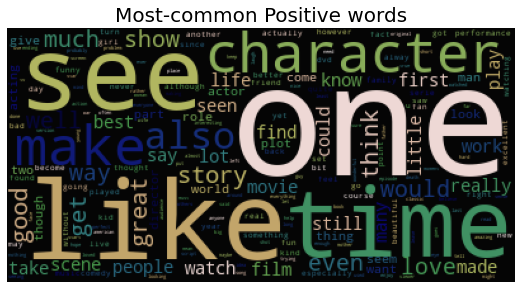

In [14]:
wordcloud(positive_data, 'Most-common Positive words')

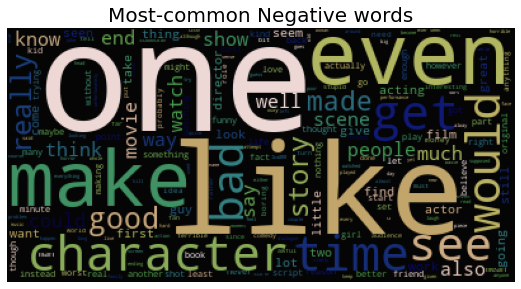

In [15]:
wordcloud(negative_data, 'Most-common Negative words')

In [16]:
target = df["label"]
features = df["cleaned_text"]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [17]:
BATCH_SIZE = 32  
embedding_dim = 16  

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply shuffle, batch and prefetch to datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
# Create text vectorizer
encoder = keras.layers.TextVectorization()

# Train tokenizer on text data
encoder.adapt(train_dataset.map(lambda feat, tar: feat))

In [21]:
# Create a sequential model
model = keras.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=embedding_dim, 
    mask_zero=True)
)
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Determine the loss, optimizer and metric to be used
model.compile(loss="binary_crossentropy", 
              optimizer="adam",
              metrics=['accuracy', 'Precision', 'Recall'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          1394768   
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          6272      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                      

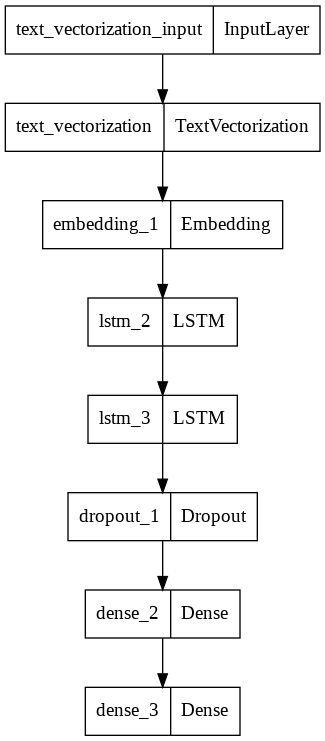

In [23]:
keras.utils.vis_utils.plot_model(model, "model.png")

In [24]:
# training model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
931/931 [==============================] - 74s 65ms/step - loss: 0.4022 - accuracy: 0.8153 - precision: 0.8010 - recall: 0.8409 - val_loss: 0.2802 - val_accuracy: 0.8844 - val_precision: 0.9065 - val_recall: 0.8568
Epoch 2/10
931/931 [==============================] - 58s 62ms/step - loss: 0.2080 - accuracy: 0.9273 - precision: 0.9246 - recall: 0.9310 - val_loss: 0.3774 - val_accuracy: 0.8552 - val_precision: 0.9326 - val_recall: 0.7652
Epoch 3/10
931/931 [==============================] - 57s 61ms/step - loss: 0.1395 - accuracy: 0.9547 - precision: 0.9543 - recall: 0.9555 - val_loss: 0.4177 - val_accuracy: 0.8748 - val_precision: 0.8837 - val_recall: 0.8628
Epoch 4/10
931/931 [==============================] - 57s 61ms/step - loss: 0.0925 - accuracy: 0.9701 - precision: 0.9691 - recall: 0.9714 - val_loss: 0.4170 - val_accuracy: 0.8749 - val_precision: 0.8524 - val_recall: 0.9064
Epoch 5/10
931/931 [==============================] - 60s 65ms/step - loss: 0.0871 - accuracy: 0

In [25]:
scores=model.evaluate(X_test,y_test) 

311/311 [==============================] - 11s 27ms/step - loss: 0.7075 - accuracy: 0.8599 - precision: 0.8441 - recall: 0.8824


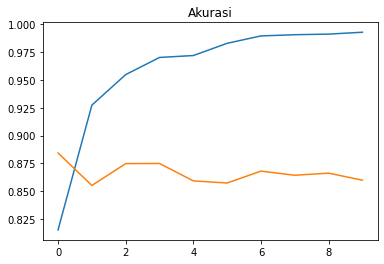

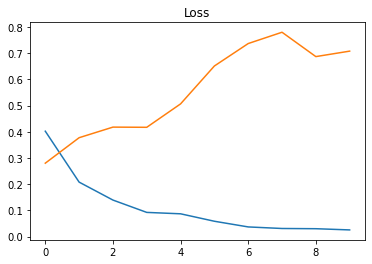

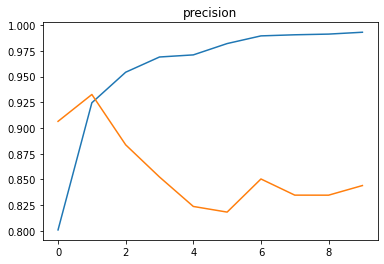

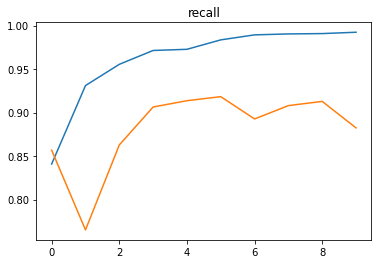

In [26]:
plt.figure()
plt.title("Akurasi")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.figure()
plt.title("Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.figure()
plt.title("precision")
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])

plt.figure()
plt.title("recall")
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])

plt.show()

In [29]:
contoh_review = ["good movie"]
prediksi = model.predict(contoh_review) # Probabilitas
prediksi.squeeze()

array(0.74957395, dtype=float32)

In [30]:
contoh_review = ["bad movie"]
prediksi = model.predict(contoh_review) # Probabilitas
prediksi.squeeze()

array(0.06204477, dtype=float32)